# CNN for HCM Classification

## Importing necessary dependencies

In [1]:
import random

from scipy import ndimage
import sklearn as skl
from sklearn import model_selection as m_s
from skimage.transform import rescale

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline 

import PIL
print('Pillow Version:', PIL.__version__)
import glob
from matplotlib import image
import os
from os import listdir

import tensorflow as tf
from tensorflow.keras import backend as K
from tensorflow.keras import Sequential
from tensorflow.keras import layers
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Conv3D
from tensorflow.keras.layers import MaxPooling3D
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import BatchNormalization

Pillow Version: 8.1.0


In [2]:
from tensorflow.compat.v1 import ConfigProto
from tensorflow.compat.v1 import InteractiveSession
#from tensorflow import ConfigProto
#from tensorflow import InteractiveSession
config = ConfigProto()
config.gpu_options.allow_growth = True
session = InteractiveSession(config=config)

In [3]:
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

Num GPUs Available:  1


## Importing Data

In [4]:
# load training images into directory
trainingpath = '/home/beepul/HCM-Project/ModifiedROI_4ChamberCine/Training'
loaded_images = list()
TopDirectory = listdir(trainingpath)

In [5]:
# Load in training table
patientlist = []
training_df = pd.read_excel('/home/beepul/HCM-Project/HCM_Methods_Data/OrganizedData/Training.xls')
for patients in training_df['PatientNumber']:
    patientlist.append(str(patients))
training_df['PatientNumber'] = patientlist
training_df.head()

,PatientNumber,RowSpacing,ColumnSpacing,Xres,Yres,X_Length,Y_Length,Outcome
0,100,1.25000,1.25000,163,163,203.75000,203.75000,0
1,101,1.25000,1.25000,169,169,211.25000,211.25000,0
2,103,1.25000,1.25000,151,151,188.75000,188.75000,0
3,107,1.25000,1.25000,143,143,178.75000,178.75000,0
4,113,1.40625,1.40625,149,149,209.53125,209.53125,0


In [6]:
# Create data frame to store relevant properties of each patient/image
num_patients = len(TopDirectory)
df = pd.DataFrame(columns = ['PatientNumber','Image','X_res','Y_res','X_length','Y_length','Outcome'])
df.PatientNumber = TopDirectory

# Load in each image and store in data frame
for i in range(num_patients):
    patient = df.PatientNumber[i]
    properties = training_df[training_df['PatientNumber'] == patient]
    index = properties.index[0]
    df.Outcome[i] = properties.Outcome[index]
    df.X_length[i], df.Y_length[i] = properties.X_Length[index], properties.Y_Length[index]
    df.X_res[i], df.Y_res[i] = properties.Xres[index], properties.Yres[index]
    imagepath = trainingpath + '/' + patient
    image_dir = listdir(imagepath)
    x_dim, y_dim = plt.imread(imagepath + '/' + str(1) + '.png').shape
    num_frames = len(image_dir)
    img_data = np.zeros((x_dim,y_dim,num_frames))
    for k in range(num_frames):
        framepath = imagepath + '/' + str(k+1) + '.png'
        img_data[:,:,(k)] = plt.imread(framepath)
    df.Image[i] = img_data

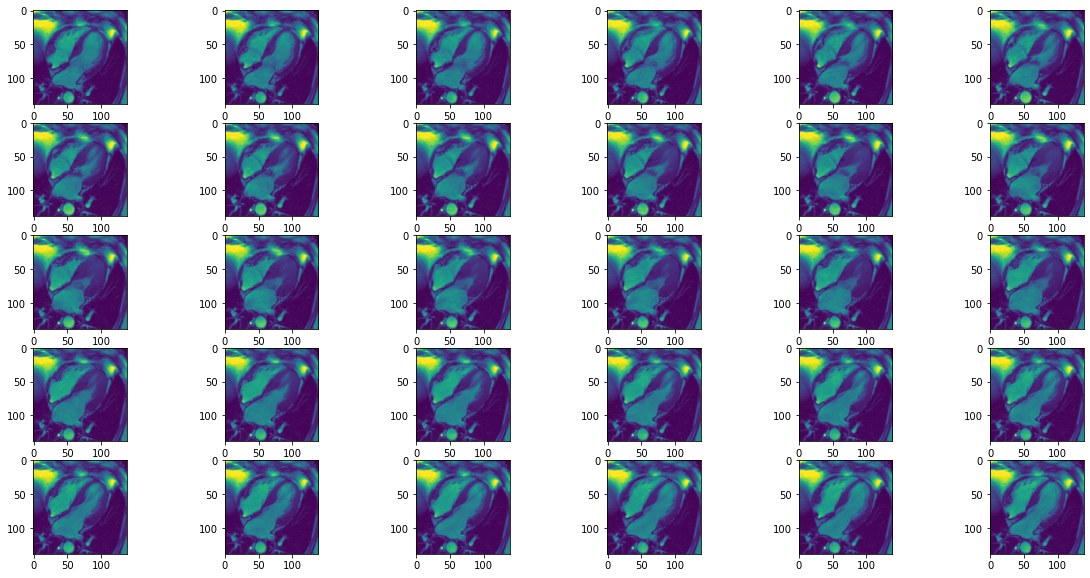

In [7]:
# Load random montage to ensure the images loaded in correctly
volume = df.Image[3]
plt.figure(figsize=(20,10))
columns = 6
for i in range(volume.shape[2]):
    image = volume[:,:,i]
    plt.subplot(5, columns, i + 1)
    plt.imshow(image)

## Data Augmentation

In [8]:
# ALL NECESSARY FUNCTIONS

# Function to properly pad images
# Input: Patient, desired x and y resolution
# Output: Resized and padded image
def pad(patient,d_x_res,d_y_res):
    image = patient.Image
    num_frames = image.shape[2]
    Y_length = patient.Y_length
    p = d_y_res*(Y_length/max_y_length)
    c_y_res = patient.Y_res
    scale = p/c_y_res
    resized_image = np.zeros((d_x_res,d_y_res,num_frames))
    for j in range(num_frames):
        frame = image[:,:,j]
        resized_frame = rescale(frame,scale)
        padded_frame = np.pad(resized_frame,((0,256-resized_frame.shape[0]),(0,256-resized_frame.shape[1])),'constant')
        resized_image[:,:,j] = padded_frame
    return resized_image

# Function to take images with 50 frames and reduce to 30 frames
def frame_selection(image):
    reduced_frames = np.empty((image.shape[0],image.shape[1],30))
    np.random.seed(10)
    odd_indices = np.array([1 + 2*k for k in range(25)])
    even_indices = np.array([2*k for k in range(26)])
    random_indices = np.random.choice(even_indices,5,replace = False)
    all_indices = np.sort(np.concatenate((odd_indices,random_indices)))
    for i, index in enumerate(all_indices):
        reduced_frames[:,:,i] = image[:,:,index]
    return reduced_frames

def train_preprocessing(image, label):
    """Process image by adding a channel."""
    processed_image = tf.expand_dims(image, axis=3)
    return processed_image, label

(array([  9.,  39.,  93., 112.,  57.,  42.,  10.,   6.,   0.,   1.]),
 array([156.6964305639252, 168.58928750753267, 180.48214445114016,
        192.37500139474764, 204.2678583383551, 216.1607152819626,
        228.05357222557006, 239.94642916917755, 251.83928611278503,
        263.7321430563925, 275.625], dtype=object),
 <BarContainer object of 10 artists>)

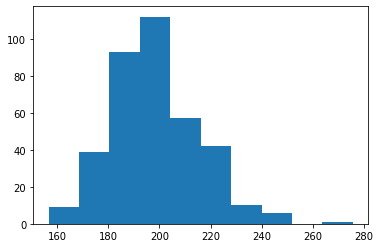

In [9]:
## Histogram of y_lengths
# This suggests that we may need to correct the padding. The largest length
# seems like an outlier and is most likely making us pad the other images too much
plt.hist(df.Y_length)

In [10]:
## Padding volumes to ensure sizes of images are correctly proportional to each other

# Find max_x and max_y
max_x_ind = pd.to_numeric(df.X_length).idxmax()
max_y_ind = pd.to_numeric(df.Y_length).idxmax()

# Fine largest image within the training set
max_volume = df.iloc[max_x_ind]
max_y_length = max_volume['Y_length']
max_y_length

275.625

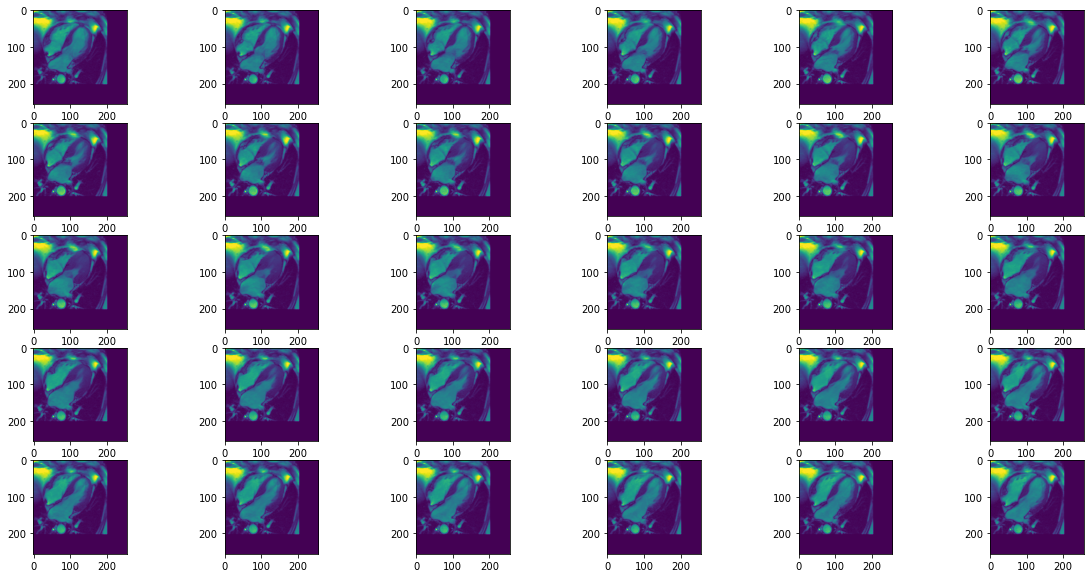

In [11]:
# Load random montage to ensure the padding works correctly
patient = df.iloc[3]
resized_image = pad(patient,256,256)
volume = resized_image
plt.figure(figsize=(20,10))
columns = 6
for i in range(volume.shape[2]):
    image = volume[:,:,i]
    plt.subplot(5, columns, i + 1)
    plt.imshow(image)

In [12]:
training_images = np.empty((df.shape[0],256,256,30))
training_labels = np.empty(df.shape[0])

In [13]:
# Fill the arrays with the images properly padded and processed
# Each image in training_images is 256 x 256 x 30

for i in range(df.shape[0]):
    patient = df.iloc[i]
    training_labels[i] = df.Outcome[i]
    padded_image = pad(patient,256,256)
    if padded_image.shape[2] == 50:
        training_images[i] =  frame_selection(padded_image)
    else:
        training_images[i] = padded_image

In [14]:
## Make validation set
## Stratified set
sss = m_s.StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=0)
for train_index, val_index in sss.split(training_images, training_labels):
    print("TRAIN Size:", len(train_index), "Val Size:", len(val_index))

TRAIN Size: 295 Val Size: 74


In [15]:
# Making the training and validation sets
sub_train_images, sub_train_labels = training_images[train_index], training_labels[train_index]
val_images, val_labels = training_images[val_index], training_labels[val_index]

In [16]:
# Load the images and labels into proper tensor format
train_loader = tf.data.Dataset.from_tensor_slices((sub_train_images, sub_train_labels))
validation_loader = tf.data.Dataset.from_tensor_slices((val_images, val_labels))

In [17]:
batch_size = 5
# Augment the on the fly during training.
train_dataset = (
    train_loader.shuffle(len(sub_train_images))
    .map(train_preprocessing)
    .batch(batch_size)
    .prefetch(2)
)

validation_dataset = (
    validation_loader.shuffle(len(val_images))
    .map(train_preprocessing)
    .batch(batch_size)
    .prefetch(2)
)

## Encoder

In [18]:
# Currently Assuming that the input images are 150x150 with 30 frames
# Channel = 1 because they are grayscale
# This architecure is DEFINITELY subject to change

# Input Data
input_data = layers.Input([256,256,30,1])

# Conv 1.1
encoder = Conv3D(4,(3,3,3), strides=(1,1,1), activation="relu",padding = "same")(input_data)
encoder = BatchNormalization(center=True, scale=True)(encoder)
encoder = Conv3D(4,(3,3,3), strides=(1,1,1), activation="relu",padding = "same")(encoder)
encoder = BatchNormalization(center=True, scale=True)(encoder)
encoder = MaxPooling3D(pool_size = (2,2,2), strides=(2,2,2))(encoder)

# Conv 2.1
encoder = Conv3D(8,(3,3,3), strides=(1,1,1), activation="relu",padding = "same")(encoder)
encoder = BatchNormalization(center=True, scale=True)(encoder)
encoder = Conv3D(8,(3,3,3), strides=(1,1,1), activation="relu",padding = "same")(encoder)
encoder = BatchNormalization(center=True, scale=True)(encoder)
encoder = MaxPooling3D(pool_size = (2,2,3), strides=(2,2,3))(encoder)

# Conv 3.1
encoder = Conv3D(16,(3,3,3), strides=(1,1,1), activation="relu",padding = "same")(encoder)
encoder = BatchNormalization(center=True, scale=True)(encoder)
encoder = Conv3D(16,(3,3,3), strides=(1,1,1), activation="relu",padding = "same")(encoder)
encoder = BatchNormalization(center=True, scale=True)(encoder)
encoder = MaxPooling3D(pool_size = (4,4,5), strides=(4,4,5), padding = "same")(encoder)

# Size of data after convolutional layers
volumesize = tf.keras.backend.int_shape(encoder)

# Fully Connected
# 1st layer
encoder = Flatten()(encoder)
dense1_size = tf.keras.backend.int_shape(encoder)

# 2nd layer
encoder = layers.Dense(100,activation = 'relu')(encoder)

# Classifying layer
encoder_cnn = layers.Dense(1,activation = 'sigmoid')(encoder)

In [19]:
# Summary of the encoder 
model = tf.keras.Model(input_data, encoder_cnn, name="encoder")
model.summary()

Model: "encoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 256, 256, 30, 1)] 0         
_________________________________________________________________
conv3d (Conv3D)              (None, 256, 256, 30, 4)   112       
_________________________________________________________________
batch_normalization (BatchNo (None, 256, 256, 30, 4)   16        
_________________________________________________________________
conv3d_1 (Conv3D)            (None, 256, 256, 30, 4)   436       
_________________________________________________________________
batch_normalization_1 (Batch (None, 256, 256, 30, 4)   16        
_________________________________________________________________
max_pooling3d (MaxPooling3D) (None, 128, 128, 15, 4)   0         
_________________________________________________________________
conv3d_2 (Conv3D)            (None, 128, 128, 15, 8)   872 

In [20]:
# Compile model.
initial_learning_rate = 0.0001
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate, decay_steps=100000, decay_rate=0.96, staircase=True
)
model.compile(
    loss="binary_crossentropy",
    optimizer=tf.keras.optimizers.Adam(learning_rate=lr_schedule),
    metrics=["acc"],
)

In [ ]:
# Define callbacks.
checkpoint_cb = tf.keras.callbacks.ModelCheckpoint(
    "3d_image_classification.h5", save_best_only=True
)
early_stopping_cb = tf.keras.callbacks.EarlyStopping(monitor="val_acc", patience=15)

# Train the model, doing validation at the end of each epoch
epochs = 10
model.fit(
    train_dataset,
    validation_data = validation_dataset,
    epochs=epochs,
    shuffle=True,
    verbose=2,
    callbacks=[checkpoint_cb, early_stopping_cb],
)

Epoch 1/10
59/59 - 18s - loss: 0.9798 - acc: 0.8441 - val_loss: 0.6735 - val_acc: 0.8649
Epoch 2/10
59/59 - 18s - loss: 0.3611 - acc: 0.8746 - val_loss: 0.6550 - val_acc: 0.7703
Epoch 3/10
59/59 - 18s - loss: 0.2694 - acc: 0.9119 - val_loss: 0.4660 - val_acc: 0.9054
Epoch 4/10
59/59 - 18s - loss: 0.1958 - acc: 0.9288 - val_loss: 0.3984 - val_acc: 0.9054
Epoch 5/10
59/59 - 18s - loss: 0.1493 - acc: 0.9288 - val_loss: 0.3165 - val_acc: 0.9054
Epoch 6/10
59/59 - 18s - loss: 0.0764 - acc: 0.9763 - val_loss: 0.2834 - val_acc: 0.9054
Epoch 7/10
59/59 - 18s - loss: 0.0426 - acc: 1.0000 - val_loss: 0.2872 - val_acc: 0.9054
Epoch 8/10
59/59 - 18s - loss: 0.0310 - acc: 0.9966 - val_loss: 0.2976 - val_acc: 0.9054
Epoch 9/10
59/59 - 18s - loss: 0.0258 - acc: 1.0000 - val_loss: 0.2923 - val_acc: 0.9054
Epoch 10/10


In [ ]:
prediction = model.predict(val_images)

In [ ]:
## Stratified K-Cross Validation
skf = m_s.StratifiedKFold(n_splits = 5)
skf.get_n_splits(np_training_images,training_labels)
for train_index, test_index in skf.split(np_training_images,training_labels):
    print("Train Size:", len(train_index), "Validation Size:", len(test_index))
    print("Train Fraction:", sum(training_labels[train_index])/len(train_index))
    print("Val Fraction:", sum(training_labels[test_index])/len(test_index))

## Do not run anything below this for now

In [7]:


## Decoder
decoder = layers.Dense(dense1_size[1])(encoder)
decoder = layers.Reshape(volumesize[1:])(decoder)

# Deconv 1.1
decoder = Conv3D(16,(3,3,3), strides=(1,1,1), activation="relu",padding = "same")(decoder)
decoder = layers.BatchNormalization(center=True, scale=True)(decoder)
decoder = Conv3D(16,(3,3,3), strides=(1,1,1), activation="relu",padding = "same")(decoder)
decoder = layers.BatchNormalization(center=True, scale=True)(decoder)
decoder = layers.UpSampling3D([5,5,5])(decoder)

# Deconv 2.1
decoder = Conv3D(8,(3,3,3), strides=(1,1,1), activation="relu",padding = "same")(decoder)
decoder = layers.BatchNormalization(center=True, scale=True)(decoder)
decoder = Conv3D(8,(3,3,3), strides=(1,1,1), activation="relu",padding = "same")(decoder)
decoder = layers.BatchNormalization(center=True, scale=True)(decoder)
decoder = layers.UpSampling3D([3,3,3])(decoder)

# Deconv 2.1
decoder = Conv3D(4,(3,3,3), strides=(1,1,1), activation="relu",padding = "same")(decoder)
decoder = layers.BatchNormalization(center=True, scale=True)(decoder)
decoder = Conv3D(4,(3,3,3), strides=(1,1,1), activation="relu",padding = "same")(decoder)
decoder = layers.BatchNormalization(center=True, scale=True)(decoder)
decoder = layers.UpSampling3D([2,2,2])(decoder)
                 

In [170]:
# Decoder Summary

In [171]:
# Full Autoencoder Summary

autoencoder_model = tf.keras.Model(input_data, decoder, name="autoencoder")
autoencoder_model.summary()

Model: "autoencoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_48 (InputLayer)        [(None, 150, 150, 30, 1)] 0         
_________________________________________________________________
conv3d_216 (Conv3D)          (None, 150, 150, 30, 4)   112       
_________________________________________________________________
batch_normalization_228 (Bat (None, 150, 150, 30, 4)   16        
_________________________________________________________________
conv3d_217 (Conv3D)          (None, 150, 150, 30, 4)   436       
_________________________________________________________________
batch_normalization_229 (Bat (None, 150, 150, 30, 4)   16        
_________________________________________________________________
max_pooling3d_104 (MaxPoolin (None, 75, 75, 15, 4)     0         
_________________________________________________________________
conv3d_218 (Conv3D)          (None, 75, 75, 15, 8)     

In [172]:
input_img = tf.keras.Input(shape=(28, 28, 1))

x = layers.Conv2D(16, (3, 3), activation='relu', padding='same')(input_img)
x = layers.MaxPooling2D((2, 2), padding='same')(x)
x = layers.Conv2D(8, (3, 3), activation='relu', padding='same')(x)
x = layers.MaxPooling2D((2, 2), padding='same')(x)
x = layers.Conv2D(8, (3, 3), activation='relu', padding='same')(x)
x = layers.MaxPooling2D((2, 2), padding='same')(x)
x = layers.Flatten()(x)
x = layers.Dense(50)(x)
# at this point the representation is 50 dimensions

x = layers.Dense(128)(x)
x = layers.Reshape([4,4,8])(x)
x = layers.Conv2D(8, (3, 3), activation='relu', padding='same')(x)
x = layers.UpSampling2D((2, 2))(x)
x = layers.Conv2D(8, (3, 3), activation='relu', padding='same')(x)
x = layers.UpSampling2D((2, 2))(x)
x = layers.Conv2D(16, (3, 3), activation='relu')(x)
x = layers.UpSampling2D((2, 2))(x)
decoded = layers.Conv2D(1, (3, 3), activation='sigmoid', padding='same')(x)

In [145]:
example = tf.keras.Model(input_img, decoded, name="autoencoder")
example.summary()

Model: "autoencoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_40 (InputLayer)        [(None, 28, 28, 1)]       0         
_________________________________________________________________
conv2d_30 (Conv2D)           (None, 28, 28, 16)        160       
_________________________________________________________________
max_pooling2d_21 (MaxPooling (None, 14, 14, 16)        0         
_________________________________________________________________
conv2d_31 (Conv2D)           (None, 14, 14, 8)         1160      
_________________________________________________________________
max_pooling2d_22 (MaxPooling (None, 7, 7, 8)           0         
_________________________________________________________________
conv2d_32 (Conv2D)           (None, 7, 7, 8)           584       
_________________________________________________________________
max_pooling2d_23 (MaxPooling (None, 4, 4, 8)           